## Efficient Graph Based Image Segmentation

In [1]:
from PIL import Image, ImageFilter
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import math
from scipy import signal

In [ ]:
import numpy as np
import math
from scipy import signal
np.seterr(over='ignore')


# some constants
WIDTH = 4.0

def newSmooth(src, sigma):
    mask = make_fgauss(sigma)
    mask = normalize(mask)
    mask = mask.reshape(3, 1)
    m = np.matmul(mask, mask.T)
    print(src.shape, mask.shape)
    #tmp = signal.convolve2d(src, m, mode="same")
    dst = signal.convolve2d(src, m, mode="same")
    return dst


# convolve image with gaussian filter
def smooth(src, sigma):
    mask = make_fgauss(sigma)
    mask = normalize(mask)
    tmp = convolve_even(src, mask)
    dst = convolve_even(tmp, mask)
    return dst


# gaussian filter
def make_fgauss(sigma):
    sigma = max(sigma, 0.01)
    length = int(math.ceil(sigma * WIDTH)) + 1
    mask = np.zeros(shape=length, dtype=float)
    for i in range(length):
        mask[i] = math.exp(-0.5 * math.pow(i / sigma, 2))#i / sigma))
    return mask


# normalize mask so it integrates to one
def normalize(mask):
    sum = 2 * np.sum(np.absolute(mask)) + abs(mask[0])
    return np.divide(mask, sum)


# convolve src with mask.  output is flipped!
def convolve_even(src, mask):
    output = np.zeros(shape=src.shape, dtype=float)
    height, width = src.shape
    length = len(mask)

    for y in range(height):
        for x in range(width):
            sum = float(mask[0] * src[y, x])
            for i in range(1, length):
                sum += mask[i] * (src[y, max(x - i, 0)] + src[y, min(x + i, width - 1)])
            output[y, x] = sum
    return output

In [ ]:
newImage = np.zeros(np.array(image).shape, dtype = 'int')

In [ ]:
image = np.array(image)

In [ ]:
newImage[:,:,0] = smooth(image[:,:,0], 0.5)

In [ ]:
newImage[:,:,1] = smooth(image[:,:,1], 0.5)

In [ ]:
newImage[:,:,2] = smooth(image[:,:,2], 0.5)

In [ ]:
plt.imshow(newImage)

In [ ]:
nImage = np.zeros(image.shape, dtype = 'int')

In [ ]:
nImage[:,:,0] = newSmooth(image[:,:,0], 0.5)

In [ ]:
nImage[:,:,1] = newSmooth(image[:,:,0], 0.5)

In [ ]:
nImage[:,:,2] = newSmooth(image[:,:,2], 0.5)

In [ ]:
plt.imshow(nImage)

In [ ]:
nImage

In [ ]:
newImage

**Hyperparameters**
1. Sigma
2. k
3. Minimum Component Size

In [2]:
class Node:
    def __init__(self, parent):
        self.rank = 0
        self.size = 1
        self.parent = parent

In [3]:
class Graph:
    def __init__(self, img, height, width):
        self.img = img #np.swapaxes(img, 0, 1)
        self.edges = []
        self.height, self.width = height, width
        self.vertexId = lambda x, y: y * self.width + x
    
    def measureDissimilarity(self, x1, y1, x2, y2):
        return np.sqrt(np.sum((self.img[y1, x1] - self.img[y2, x2])**2))
    
    def createEdge(self, x1, y1, x2, y2):
        weight = self.measureDissimilarity(x1, y1, x2, y2)
        return np.array([self.vertexId(x1, y1), self.vertexId(x2, y2), weight])
        
    def build(self):
        for y in range(self.height):
            for x in range(self.width):
                if x < self.width - 1:
                    self.edges.append(self.createEdge(x, y, x+1, y))
                if y < self.height - 1:
                    self.edges.append(self.createEdge(x, y, x, y+1))
                if (x < self.width - 1) and (y < self.height - 1):
                    self.edges.append(self.createEdge(x, y, x+1, y+1))
                if (x < self.width - 1) and (y > 0):
                    self.edges.append(self.createEdge(x, y, x+1, y-1))
        self.edges = np.array(self.edges)

In [4]:
class Forest:
    def __init__(self, nElements):
        self.nSets = nElements
        self.nNodes = []
        for i in range(self.nSets):
            self.nNodes.append(Node(i))
    
    def find(self, x):
        y = int(x)
        #print(x, y)
        while y != self.nNodes[y].parent:
            y = self.nNodes[y].parent
        self.nNodes[int(x)].parent = y
        return y
    
    def join(self, x, y):
        x, y = int(x), int(y)
        if self.nNodes[x].rank > self.nNodes[y].rank:
            self.nNodes[y].parent = x
            self.nNodes[x].size += self.nNodes[y].size
        else:
            self.nNodes[x].parent = y
            self.nNodes[y].size += self.nNodes[x].size
            if self.nNodes[x].rank == self.nNodes[y].rank:
                self.nNodes[x].rank += 1
        self.nSets -= 1
        
    def sizeOfComponent(self, x):
        return self.nNodes[x].size

In [5]:
class SegmentedGraph:
    def __init__(self, G, k, minComSize):
        self.height, self.width = G.height, G.width
        self.edges = deepcopy(G.edges)
        self.nVertices = G.height * G.width
        self.nEdges = G.edges.shape[0]
        self.edges[0: self.nEdges, :] = self.edges[self.edges[0:self.nEdges, 2].argsort()]
        self.k, self.minComponentSize = k, minComSize
        self.forest = None
        self.threshold = np.zeros((self.nVertices))
        #print(self.nEdges, self.nVertices, self.nVertices*4)
        
    def buildForest(self):
        self.forest = Forest(self.nVertices)
        for i in range(self.nVertices):
            self.threshold[i] = self.getThreshold(self.forest.nNodes[i].size)
        
    def getThreshold(self, cSize):
        return self.k / cSize
    
    def build(self):
        self.buildForest()
        for i in range(self.nEdges):
            edge = self.edges[i]
            weight = edge[2]
            a, b = self.forest.find(edge[0]), self.forest.find(edge[1])
            if a != b:
                if (weight <= self.threshold[a]) and (weight <= self.threshold[b]):
                    self.forest.join(a, b)
                    a = self.forest.find(a)
                    self.threshold[a] = weight + self.getThreshold(self.forest.sizeOfComponent(a))
        for i in range(self.nEdges):
            edge = self.edges[i]
            a, b = self.forest.find(edge[0]), self.forest.find(edge[1])
            if (a != b) and ((self.forest.sizeOfComponent(a) < self.minComponentSize) or (self.forest.sizeOfComponent(b) < self.minComponentSize)):
                self.forest.join(a, b)
        return deepcopy(self.forest)

In [24]:
class Filter:
    def __init__(self, sigma):
        self.sigma = sigma
        self.kernel = None
        self.width = 4
        
    def blur(self, src):
        return signal.convolve2d(src, self.kernel, mode="same")
        
    def buildGaussianKernel(self):
        self.sigma = max(self.sigma, 0.01)
        length = int(math.ceil(self.sigma * self.width)) + 1
        self.kernel = np.zeros(shape=length, dtype=float)
        for i in range(length):
            self.kernel[i] = math.exp(-0.5 * math.pow(i / self.sigma, 2))
        # normalize mask so it integrates to one
        sum = 2 * np.sum(np.absolute(self.kernel)) + abs(self.kernel[0])
        self.kernel = np.divide(self.kernel, sum)
        self.kernel = self.kernel.reshape(self.kernel.shape[0], 1)
        self.kernel = np.matmul(self.kernel, self.kernel.T) #Guassian Filter is a seperable filter

In [25]:
class SegmentImage:
    def __init__(self, imgPath, sigma, k, minComSize):
        self.imgPath, self.sigma = imgPath, sigma
        self.k, self.minComponentSize = k, minComSize
        self.img, self.width, self.height = None, None, None
        self.blurredImage = None
        self.forest = None
        self.outputImg, self.nChannels = None, None
        self.filter = Filter(self.sigma)
        
    def getImage(self):
        self.img = Image.open(self.imgPath)
        self.width, self.height = self.img.size
        self.img = np.array(self.img)
        self.blurredImage = np.zeros(self.img.shape)
    
    def smoothingWithGaussianFilter(self): #blurred image
        self.filter.buildGaussianKernel()
        self.outputImg = np.zeros(self.blurredImage.shape, dtype='int')
        try: self.nChannels = self.outputImg.shape[2]
        except: self.nChannels = 1
        if self.nChannels == 1: self.blurredImage[:,:] = self.filter.blur(self.img[:,:])
        else:
            for i in range(self.nChannels): self.blurredImage[:,:,i] = self.filter.blur(self.img[:,:,i])
        
    def build(self):
        self.getImage()
        self.smoothingWithGaussianFilter()
        G = Graph(self.blurredImage, self.height, self.width)
        G.build()
        segmentedGraph = SegmentedGraph(G, self.k, self.minComponentSize)
        self.forest = segmentedGraph.build()
        del segmentedGraph
        colors = np.random.randint(0, 256, (G.height * G.width, self.nChannels), dtype='int')
        for y in range(G.height):
            for x in range(G.width):
                head = self.forest.find(y * G.width + x)
                if self.nChannels == 1: self.outputImg[y, x] = colors[head]
                else: self.outputImg[y, x, : ] = colors[head]
        del G, colors
        return self.img, self.outputImg

In [11]:
def run(imgPath, sigma, k, minComponentSize):
    segImg = SegmentImage(imgPath, sigma, k, minComponentSize)
    img, outputImg = segImg.build()
    del segImg
    fig = plt.figure(figsize=(16, 10))
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    a.set_title('Original Image')
    a = fig.add_subplot(1, 2, 2)
    plt.imshow(outputImg)
    a.set_title('Segmented Image')
    plt.show()
    del img, outputImg

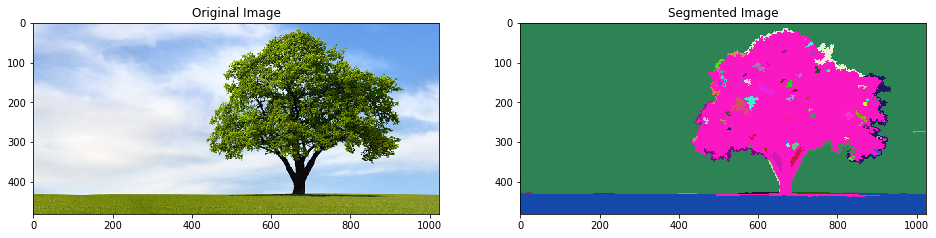

In [16]:
run('Data/BigTree.jpg', 0.5, 300, 50)

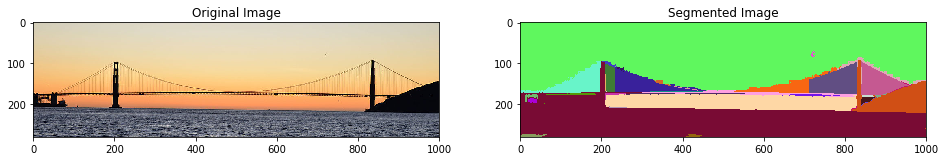

In [17]:
run('Data/bridge.jpg', 0.5, 300, 50)

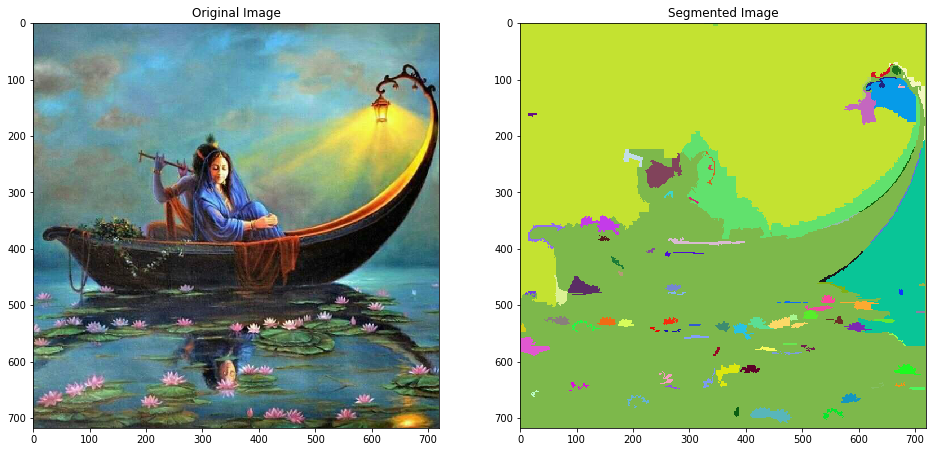

In [18]:
run('Data/krishna.jpg', 0.5, 300, 50)

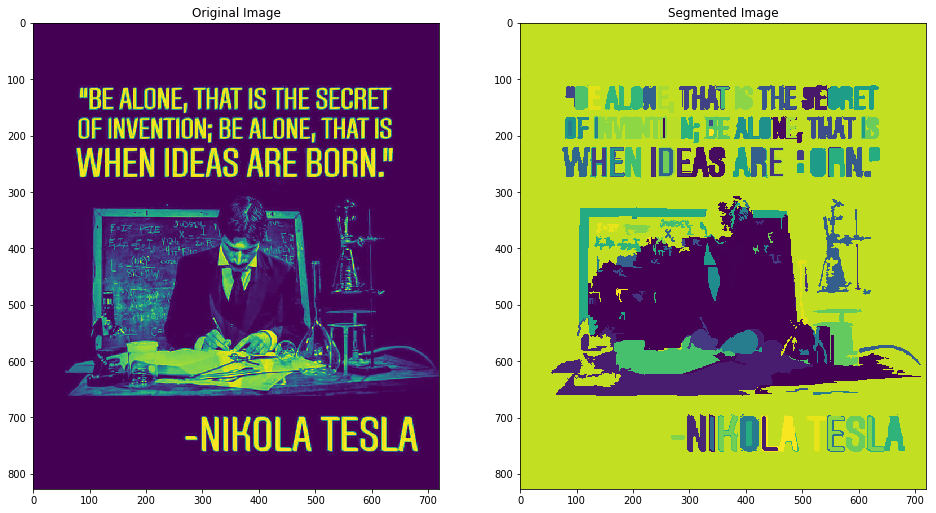

In [19]:
run('Data/tesla_gray.jpg', 0.5, 300, 50)

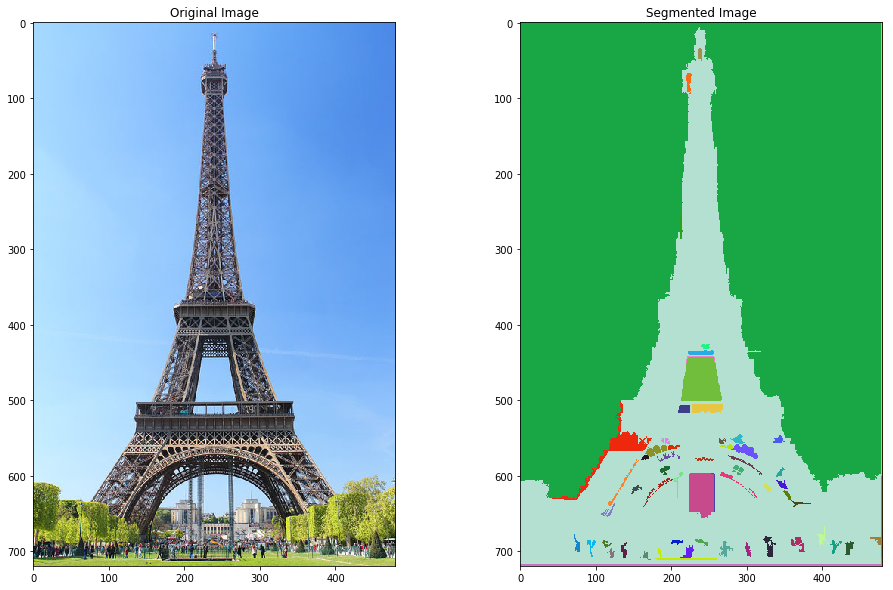

In [23]:
run('Data/paris.jpg', 0.8, 300, 50)

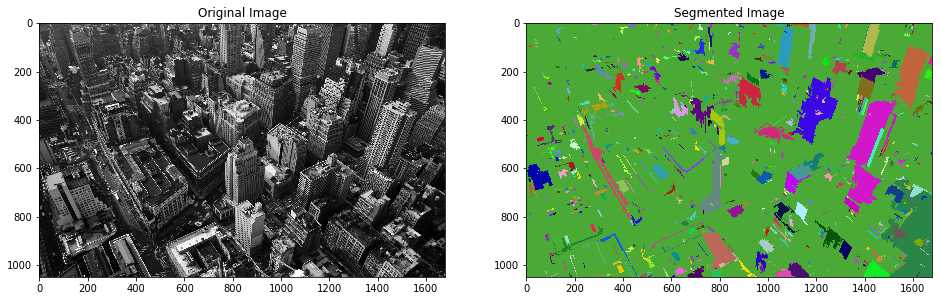

In [26]:
run('Data/wallpaper.jpg', 0.5, 300, 50)